# UAV Environment Testing

测试当前系统中的UAV环境，验证环境功能和性能。

## 系统架构验证
1. **环境层核心功能** - OpenAI Gym接口实现
2. **组件集成** - UAV、用户、信道、信号处理模块
3. **统一接口** - 通过统一接口调用utils功能
4. **性能分析** - 不同配置下的环境性能

## 测试内容
1. 环境初始化和配置测试
2. Gym接口功能验证
3. UAV控制和动态测试
4. 信道和信号处理集成测试
5. 奖励机制和终止条件测试
6. 完整episode运行测试
7. 性能对比和分析


In [8]:
# 导入和环境设置
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../src'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from typing import List, Dict, Any
import time

# 导入模块
from environment.uav_env import UAVEnvironment
from environment.uav import UAV
from environment.users import UserManager, GroundUser
from utils.channel import ChannelModel
from utils.signal import SignalProcessor

# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置随机种子以便重现
np.random.seed(42)

# 配置绘图
plt.style.use('default')
sns.set_palette("husl")

print("✅ 环境设置完成")


✅ 环境设置完成


## 1. 环境初始化和配置测试

测试不同配置参数下的环境初始化功能。


In [9]:
def test_environment_initialization():
    """测试环境初始化功能"""
    print("🔧 测试环境初始化...")
    
    # 默认配置
    env_default = UAVEnvironment()
    print(f"✅ 默认环境创建成功")
    print(f"   - 环境大小: {env_default.env_size}")
    print(f"   - 用户数量: {env_default.num_users}")
    print(f"   - 天线数量: {env_default.num_antennas}")
    print(f"   - 总步数: {env_default.total_steps}")
    
    # 自定义配置
    custom_config = {
        'env_size': (150, 150, 75),
        'num_users': 4,
        'num_antennas': 12,
        'flight_time': 300.0,
        'transmit_power': 1.0,
        'max_speed': 50.0
    }
    
    env_custom = UAVEnvironment(**custom_config)
    print(f"✅ 自定义环境创建成功")
    print(f"   - 环境大小: {env_custom.env_size}")
    print(f"   - 用户数量: {env_custom.num_users}")
    print(f"   - 天线数量: {env_custom.num_antennas}")
    print(f"   - 总步数: {env_custom.total_steps}")
    
    # 验证观察空间和动作空间
    print(f"\n📊 空间验证:")
    print(f"   - 观察空间形状: {env_default.observation_space.shape}")
    print(f"   - 动作空间: {env_default.action_space}")
    print(f"   - 动作数量: {env_default.action_space.n}")
    
    return env_default, env_custom

# 运行测试
env_default, env_custom = test_environment_initialization()


🔧 测试环境初始化...
✅ 默认环境创建成功
   - 环境大小: (100, 100, 50)
   - 用户数量: 2
   - 天线数量: 8
   - 总步数: 2500
✅ 自定义环境创建成功
   - 环境大小: (150, 150, 75)
   - 用户数量: 4
   - 天线数量: 12
   - 总步数: 3000

📊 空间验证:
   - 观察空间形状: (10,)
   - 动作空间: Discrete(5)
   - 动作数量: 5


## 2. Gym接口功能验证

测试OpenAI Gym标准接口的实现。


In [10]:
def test_gym_interface():
    """测试Gym接口的基本功能"""
    print("🔧 测试Gym接口...")
    
    env = UAVEnvironment()
    
    # 测试重置功能
    observation, info = env.reset()
    print(f"✅ 重置功能测试通过")
    print(f"   - 观察维度: {observation.shape}")
    print(f"   - 观察范围: [{observation.min():.2f}, {observation.max():.2f}]")
    print(f"   - Info类型: {type(info)}")
    
    # 测试step功能
    actions_to_test = [0, 1, 2, 3, 4]  # 所有可能的动作
    step_results = []
    
    for action in actions_to_test:
        obs, reward, terminated, truncated, info = env.step(action)
        step_results.append({
            'action': action,
            'observation_shape': obs.shape,
            'reward': reward,
            'terminated': terminated,
            'truncated': truncated,
            'info_keys': list(info.keys()) if isinstance(info, dict) else str(type(info))
        })
    
    print(f"\n📊 Step功能测试结果:")
    for result in step_results[:3]:  # 显示前3个测试结果
        print(f"   动作{result['action']}: reward={result['reward']:.4f}, "
              f"terminated={result['terminated']}, obs_shape={result['observation_shape']}")
    
    # 测试观察空间边界
    assert env.observation_space.contains(observation), "观察不在定义的空间内"
    print(f"✅ 观察空间验证通过")
    
    # 测试动作空间
    for action in range(env.action_space.n):
        assert env.action_space.contains(action), f"动作{action}不在动作空间内"
    print(f"✅ 动作空间验证通过")
    
    return env, step_results

# 运行测试
env_gym, step_results = test_gym_interface()


🔧 测试Gym接口...
✅ 重置功能测试通过
   - 观察维度: (10,)
   - 观察范围: [0.00, 80.00]
   - Info类型: <class 'dict'>
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 9.768920632978065e-05
MRT Debug: User 1, w norm before = 1.0
MRT Debug: User 1, w power = 1.0
MRT Debug: User 2, channel norm = 0.00010735026592655974
MRT Debug: User 2, w norm before = 1.0
MRT Debug: User 2, w power = 1.0
MRT Debug: total_power before normalization = 2.0
MRT Debug: scale_factor = 0.5
MRT Debug: final total power = 0.5
Start calculating throughput for all users
sinr_values: [0.53821802 0.11997074]
signal processor throughput_values: [0.62126    0.16346105]
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 9.768920632978065e-05
MRT Debug: User 1, w norm before = 1.0
MRT Debug: User 1, w power = 1.0
MRT Debug: User 2, channel norm = 0.00010735026592655974
MRT Debug: User 2, w norm before = 1.0
MRT Debug: User 2, w power =

## 3. UAV控制和动态测试

测试UAV的移动控制和物理约束。


🔧 测试UAV控制...
初始位置: [ 0.  0. 50.]
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 0.00010279552957303379
MRT Debug: User 1, w norm before = 0.9999999999999998
MRT Debug: User 1, w power = 0.9999999999999996
MRT Debug: User 2, channel norm = 0.00010761096138398872
MRT Debug: User 2, w norm before = 1.0
MRT Debug: User 2, w power = 1.0
MRT Debug: total_power before normalization = 1.9999999999999996
MRT Debug: scale_factor = 0.5
MRT Debug: final total power = 0.4999999999999999
Start calculating throughput for all users
sinr_values: [0.60046491 0.11901872]
signal processor throughput_values: [0.67849105 0.16223417]
步骤1: 动作=0, 位置=[ 3.  0. 50.], 奖励=-41.5669
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 0.00010279552957303379
MRT Debug: User 1, w norm before = 0.9999999999999998
MRT Debug: User 1, w power = 0.9999999999999996
MRT Debug: User 2, channel norm = 0.0001076109613839

d:\WorkAPPs\miniconda\envs\uav_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\WorkAPPs\miniconda\envs\uav_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\WorkAPPs\miniconda\envs\uav_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\WorkAPPs\miniconda\envs\uav_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\WorkAPPs\miniconda\envs\uav_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36712 (\N{CJK UNIFIE

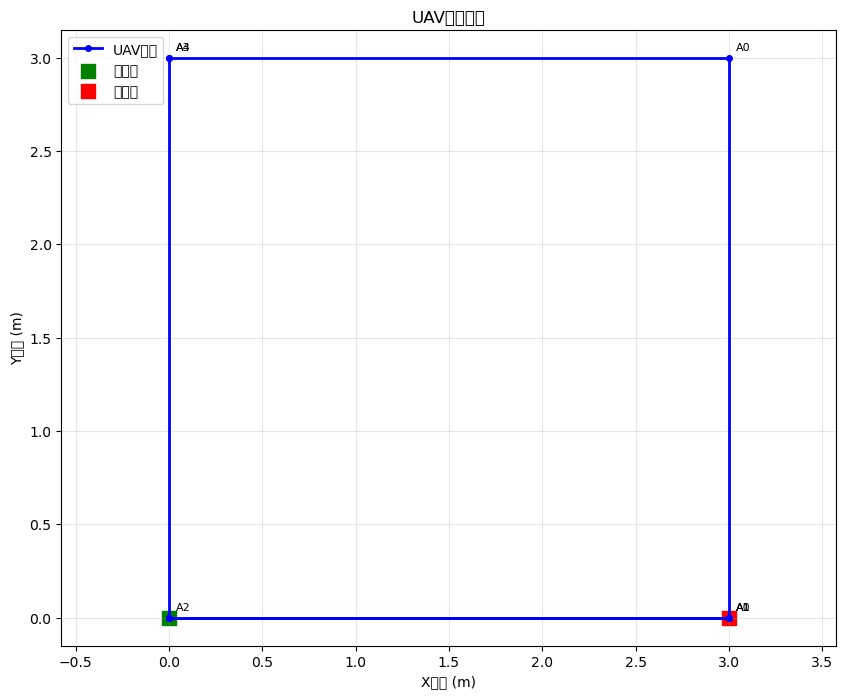

In [11]:
def test_uav_control():
    """测试UAV控制功能"""
    print("🔧 测试UAV控制...")
    
    env = UAVEnvironment()
    env.reset()
    
    # 记录UAV轨迹
    trajectory = []
    actions_taken = []
    
    # 测试各种动作
    test_actions = [0, 1, 2, 3, 4, 0, 1]  # 前进、后退、左、右、停止等
    
    print(f"初始位置: {env.uav.get_position()}")
    trajectory.append(env.uav.get_position().copy())
    
    for i, action in enumerate(test_actions):
        # 执行动作
        obs, reward, terminated, truncated, info = env.step(action)
        current_pos = env.uav.get_position()
        trajectory.append(current_pos.copy())
        actions_taken.append(action)
        
        print(f"步骤{i+1}: 动作={action}, 位置={current_pos}, 奖励={reward:.4f}")
        
        if terminated or truncated:
            print(f"Episode终止于步骤{i+1}")
            break
    
    # 分析UAV移动
    trajectory = np.array(trajectory)
    
    print(f"\n📊 UAV动态分析:")
    print(f"   - 总移动距离: {np.sum(np.linalg.norm(np.diff(trajectory, axis=0), axis=1)):.2f}")
    print(f"   - X轴变化范围: [{trajectory[:, 0].min():.2f}, {trajectory[:, 0].max():.2f}]")
    print(f"   - Y轴变化范围: [{trajectory[:, 1].min():.2f}, {trajectory[:, 1].max():.2f}]")
    print(f"   - 最终位置: {trajectory[-1]}")
    
    # 可视化轨迹
    plt.figure(figsize=(10, 8))
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-o', markersize=4, linewidth=2, label='UAV轨迹')
    plt.scatter(trajectory[0, 0], trajectory[0, 1], c='green', s=100, marker='s', label='起始点')
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='red', s=100, marker='s', label='结束点')
    
    # 标记动作
    for i, action in enumerate(actions_taken):
        if i < len(trajectory) - 1:
            plt.annotate(f'A{action}', (trajectory[i+1, 0], trajectory[i+1, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('X位置 (m)')
    plt.ylabel('Y位置 (m)')
    plt.title('UAV移动轨迹')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
    
    return trajectory, actions_taken

# 运行测试
trajectory, actions = test_uav_control()


## 4. 信道和信号处理集成测试

测试信道模型和信号处理模块的集成效果。


🔧 测试信道和信号处理集成...
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 9.971682082588982e-05
MRT Debug: User 1, w norm before = 1.0000000000000002
MRT Debug: User 1, w power = 1.0000000000000004
MRT Debug: User 2, channel norm = 0.0001007948844662815
MRT Debug: User 2, w norm before = 1.0
MRT Debug: User 2, w power = 1.0
MRT Debug: total_power before normalization = 2.0000000000000004
MRT Debug: scale_factor = 0.49999999999999994
MRT Debug: final total power = 0.49999999999999994
Start calculating throughput for all users
sinr_values: [0.62649701 0.18955386]
signal processor throughput_values: [0.70176817 0.2504206 ]
   MRT + equal: 0.9522
MRT Debug: num_users=2, num_antennas=8
MRT Debug: power_constraint=0.5
MRT Debug: User 1, channel norm = 9.971682082588982e-05
MRT Debug: User 1, w norm before = 1.0000000000000002
MRT Debug: User 1, w power = 1.0000000000000004
MRT Debug: User 2, channel norm = 0.0001007948844662815
MRT Debug: User 

C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 26463 (\N{CJK UNIFIED IDEOGRAPH-675F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 36171 (\N{CJK UNIFIED IDEOGRAPH-8D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\12107\AppData\Local\Temp\ipykernel_32340\353886954.py:71: UserWarning: Glyph 27861 (\N{CJK 

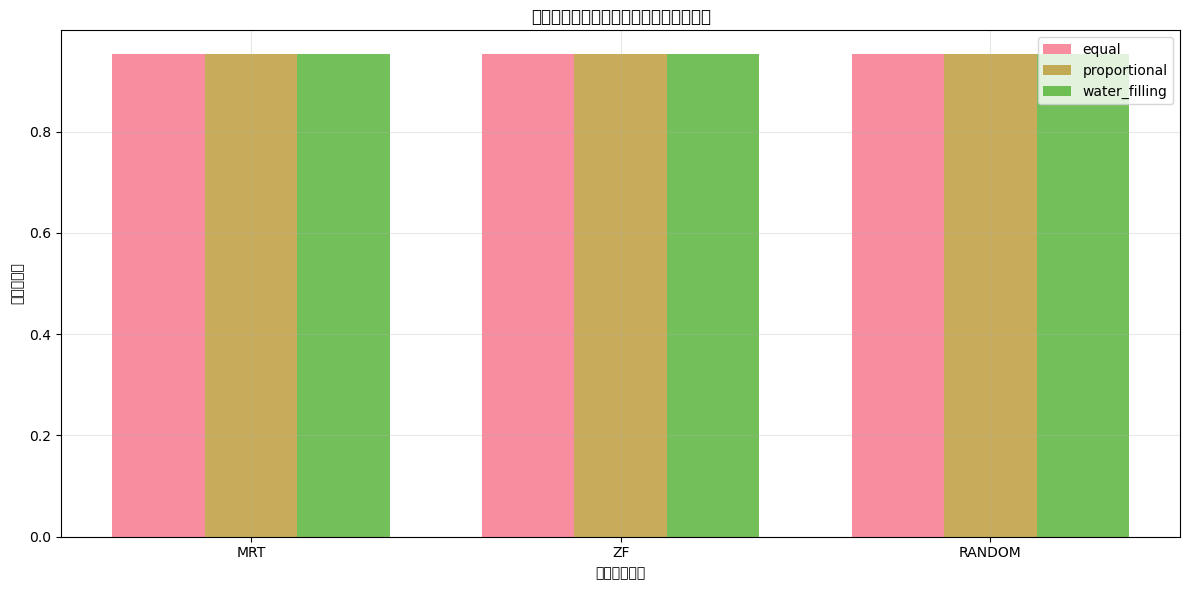

In [12]:
def test_channel_signal_integration():
    """测试信道和信号处理集成"""
    print("🔧 测试信道和信号处理集成...")
    
    env = UAVEnvironment()
    env.reset()
    
    # 测试不同波束赋形方法
    beamforming_methods = ['mrt', 'zf', 'random']
    power_strategies = ['equal', 'proportional', 'water_filling']
    
    results = {}
    
    for bf_method in beamforming_methods:
        results[bf_method] = {}
        for power_strategy in power_strategies:
            try:
                # 临时设置波束赋形方法
                original_method = getattr(env, 'beamforming_method', 'mrt')
                original_strategy = getattr(env, 'power_optimization_strategy', 'equal')
                
                env.beamforming_method = bf_method
                env.power_optimization_strategy = power_strategy
                
                # 计算当前吞吐量
                throughput = env._calculate_throughput()
                results[bf_method][power_strategy] = throughput
                
                # 恢复原设置
                env.beamforming_method = original_method
                env.power_optimization_strategy = original_strategy
                
                print(f"   {bf_method.upper()} + {power_strategy}: {throughput:.4f}")
                
            except Exception as e:
                print(f"   {bf_method.upper()} + {power_strategy}: 失败 - {str(e)[:50]}")
                results[bf_method][power_strategy] = None
    
    # 分析结果
    print(f"\n📊 信号处理性能分析:")
    valid_results = {}
    for method, strategies in results.items():
        valid_strategies = {k: v for k, v in strategies.items() if v is not None}
        if valid_strategies:
            valid_results[method] = valid_strategies
            avg_performance = np.mean(list(valid_strategies.values()))
            print(f"   {method.upper()}: 平均吞吐量 = {avg_performance:.4f}")
    
    # 可视化性能对比
    if valid_results:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        methods = list(valid_results.keys())
        strategies = list(next(iter(valid_results.values())).keys())
        
        x = np.arange(len(methods))
        width = 0.25
        
        for i, strategy in enumerate(strategies):
            values = [valid_results[method].get(strategy, 0) for method in methods]
            ax.bar(x + i*width, values, width, label=strategy, alpha=0.8)
        
        ax.set_xlabel('波束赋形方法')
        ax.set_ylabel('系统吞吐量')
        ax.set_title('不同波束赋形方法和功率策略的性能对比')
        ax.set_xticks(x + width)
        ax.set_xticklabels([m.upper() for m in methods])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

# 运行测试
signal_results = test_channel_signal_integration()


## 5. 奖励机制和终止条件测试

测试环境的奖励计算和episode终止逻辑。


In [ ]:
def test_reward_and_termination():
    """测试奖励机制和终止条件"""
    print("🔧 测试奖励机制和终止条件...")
    
    env = UAVEnvironment()
    env.reset()
    
    # 记录奖励和状态变化
    rewards_history = []
    positions_history = []
    terminated_history = []
    truncated_history = []
    throughput_history = []
    
    # 执行一系列动作
    test_actions = [0, 0, 0, 1, 1, 2, 2, 3, 3, 4] * 5  # 重复动作序列
    
    print(f"初始状态:")
    print(f"   - UAV位置: {env.uav.get_position()}")
    print(f"   - 当前步数: {env.current_step}")
    print(f"   - 剩余时间: {env.remaining_time:.1f}s")
    
    for i, action in enumerate(test_actions):
        if i >= 30:  # 限制测试步数
            break
            
        obs, reward, terminated, truncated, info = env.step(action)
        
        # 记录数据
        rewards_history.append(reward)
        positions_history.append(env.uav.get_position().copy())
        terminated_history.append(terminated)
        truncated_history.append(truncated)
        
        # 获取当前吞吐量
        current_throughput = env._calculate_throughput()
        throughput_history.append(current_throughput)
        
        if i < 10 or i % 5 == 0:  # 显示部分详细信息
            print(f"步骤{i+1:2d}: 动作={action}, 奖励={reward:7.3f}, "
                  f"吞吐量={current_throughput:.4f}, "
                  f"terminated={terminated}, truncated={truncated}")
        
        if terminated or truncated:
            print(f"Episode在步骤{i+1}终止")
            break
    
    # 分析奖励模式
    rewards_history = np.array(rewards_history)
    throughput_history = np.array(throughput_history)
    
    print(f"\n📊 奖励分析:")
    print(f"   - 总奖励: {np.sum(rewards_history):.3f}")
    print(f"   - 平均奖励: {np.mean(rewards_history):.3f}")
    print(f"   - 奖励标准差: {np.std(rewards_history):.3f}")
    print(f"   - 最大奖励: {np.max(rewards_history):.3f}")
    print(f"   - 最小奖励: {np.min(rewards_history):.3f}")
    
    print(f"\n📊 吞吐量分析:")
    print(f"   - 平均吞吐量: {np.mean(throughput_history):.4f}")
    print(f"   - 吞吐量变化: {np.std(throughput_history):.4f}")
    
    # 可视化奖励和吞吐量变化
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # 奖励变化
    steps = np.arange(1, len(rewards_history) + 1)
    ax1.plot(steps, rewards_history, 'b-o', markersize=4)
    ax1.set_xlabel('步数')
    ax1.set_ylabel('奖励')
    ax1.set_title('奖励随时间变化')
    ax1.grid(True, alpha=0.3)
    
    # 吞吐量变化
    ax2.plot(steps, throughput_history, 'g-s', markersize=4)
    ax2.set_xlabel('步数')
    ax2.set_ylabel('系统吞吐量')
    ax2.set_title('系统吞吐量随时间变化')
    ax2.grid(True, alpha=0.3)
    
    # UAV轨迹
    positions_history = np.array(positions_history)
    ax3.plot(positions_history[:, 0], positions_history[:, 1], 'r-o', markersize=4)
    ax3.scatter(env.start_position[0], env.start_position[1], c='green', s=100, marker='s', label='起点')
    ax3.scatter(env.end_position[0], env.end_position[1], c='red', s=100, marker='s', label='终点')
    ax3.set_xlabel('X位置 (m)')
    ax3.set_ylabel('Y位置 (m)')
    ax3.set_title('UAV移动轨迹')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return rewards_history, throughput_history, positions_history

# 运行测试
rewards, throughputs, positions = test_reward_and_termination()


🔧 测试奖励机制和终止条件...
初始状态:
   - UAV位置: [ 0.  0. 50.]
   - 当前步数: 0


AttributeError: 'UAVEnvironment' object has no attribute 'remaining_time_ratio'

## 6. 完整Episode运行测试

测试完整的episode执行，包括成功和失败的情况。


In [ ]:
def test_complete_episodes():
    """测试完整episode运行"""
    print("🔧 测试完整episode运行...")
    
    env = UAVEnvironment(flight_time=100.0)  # 缩短时间以便测试
    
    # 测试多个episode
    num_episodes = 3
    episode_results = []
    
    for episode in range(num_episodes):
        print(f"\n--- Episode {episode + 1} ---")
        
        obs, info = env.reset()
        episode_data = {
            'episode': episode + 1,
            'steps': 0,
            'total_reward': 0.0,
            'final_position': None,
            'success': False,
            'termination_reason': 'unknown',
            'throughputs': [],
            'positions': []
        }
        
        # 简单策略：向目标点移动
        while True:
            # 计算朝向目标的动作（简化版）
            current_pos = env.uav.get_position()
            target_pos = env.end_position
            
            # 简单的方向选择逻辑
            dx = target_pos[0] - current_pos[0]
            dy = target_pos[1] - current_pos[1]
            
            if abs(dx) > abs(dy):
                action = 0 if dx > 0 else 1  # 前进或后退
            else:
                action = 2 if dy > 0 else 3  # 右或左
            
            # 偶尔停止
            if episode_data['steps'] % 10 == 0:
                action = 4
            
            # 执行动作
            obs, reward, terminated, truncated, info = env.step(action)
            
            # 记录数据
            episode_data['steps'] += 1
            episode_data['total_reward'] += reward
            episode_data['throughputs'].append(env._calculate_throughput())
            episode_data['positions'].append(current_pos.copy())
            
            # 检查终止条件
            if terminated:
                distance_to_target = np.linalg.norm(current_pos - target_pos)
                if distance_to_target < 5.0:
                    episode_data['success'] = True
                    episode_data['termination_reason'] = 'success'
                else:
                    episode_data['termination_reason'] = 'boundary'
                break
            elif truncated:
                episode_data['termination_reason'] = 'timeout'
                break
            
            # 防止无限循环
            if episode_data['steps'] > 1000:
                episode_data['termination_reason'] = 'max_steps'
                break
        
        episode_data['final_position'] = env.uav.get_position().copy()
        episode_results.append(episode_data)
        
        # 打印episode结果
        print(f"   步数: {episode_data['steps']}")
        print(f"   总奖励: {episode_data['total_reward']:.3f}")
        print(f"   平均奖励: {episode_data['total_reward']/max(1, episode_data['steps']):.3f}")
        print(f"   成功: {episode_data['success']}")
        print(f"   终止原因: {episode_data['termination_reason']}")
        print(f"   最终位置: {episode_data['final_position']}")
        
        final_distance = np.linalg.norm(episode_data['final_position'] - env.end_position)
        print(f"   距离目标: {final_distance:.2f}m")
    
    # 汇总分析
    print(f"\n📊 Episode汇总分析:")
    success_rate = sum(ep['success'] for ep in episode_results) / len(episode_results)
    avg_steps = np.mean([ep['steps'] for ep in episode_results])
    avg_reward = np.mean([ep['total_reward'] for ep in episode_results])
    
    print(f"   - 成功率: {success_rate:.2%}")
    print(f"   - 平均步数: {avg_steps:.1f}")
    print(f"   - 平均总奖励: {avg_reward:.3f}")
    
    # 终止原因统计
    termination_reasons = [ep['termination_reason'] for ep in episode_results]
    unique_reasons, counts = np.unique(termination_reasons, return_counts=True)
    print(f"   - 终止原因分布:")
    for reason, count in zip(unique_reasons, counts):
        print(f"     * {reason}: {count} episodes")
    
    # 可视化episode对比
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 奖励对比
    episodes_num = [ep['episode'] for ep in episode_results]
    total_rewards = [ep['total_reward'] for ep in episode_results]
    colors = ['green' if ep['success'] else 'red' for ep in episode_results]
    
    ax1.bar(episodes_num, total_rewards, color=colors, alpha=0.7)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('总奖励')
    ax1.set_title('各Episode总奖励对比')
    ax1.grid(True, alpha=0.3)
    
    # 步数对比
    steps = [ep['steps'] for ep in episode_results]
    ax2.bar(episodes_num, steps, color=colors, alpha=0.7)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('步数')
    ax2.set_title('各Episode步数对比')
    ax2.grid(True, alpha=0.3)
    
    # 轨迹对比
    for i, ep in enumerate(episode_results):
        positions = np.array(ep['positions'])
        if len(positions) > 0:
            label = f"Episode {ep['episode']} ({'成功' if ep['success'] else '失败'})"
            ax3.plot(positions[:, 0], positions[:, 1], '-o', markersize=2, 
                    alpha=0.7, label=label)
    
    ax3.scatter(env.start_position[0], env.start_position[1], 
               c='green', s=100, marker='s', label='起点', zorder=5)
    ax3.scatter(env.end_position[0], env.end_position[1], 
               c='red', s=100, marker='s', label='终点', zorder=5)
    ax3.set_xlabel('X位置 (m)')
    ax3.set_ylabel('Y位置 (m)')
    ax3.set_title('各Episode轨迹对比')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')
    
    # 吞吐量趋势
    for i, ep in enumerate(episode_results):
        if ep['throughputs']:
            steps_range = np.arange(1, len(ep['throughputs']) + 1)
            label = f"Episode {ep['episode']}"
            ax4.plot(steps_range, ep['throughputs'], '-', alpha=0.7, label=label)
    
    ax4.set_xlabel('步数')
    ax4.set_ylabel('系统吞吐量')
    ax4.set_title('各Episode吞吐量变化')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return episode_results

# 运行测试
episode_results = test_complete_episodes()


## 7. 性能压力测试

测试环境在高负载和边界条件下的性能表现。


In [ ]:
def test_performance_stress():
    """测试环境性能和压力"""
    print("🔧 测试环境性能和压力...")
    
    # 测试不同配置下的性能
    test_configs = [
        {'name': '标准配置', 'num_users': 2, 'num_antennas': 8, 'env_size': (100, 100, 50)},
        {'name': '高用户密度', 'num_users': 8, 'num_antennas': 16, 'env_size': (100, 100, 50)},
        {'name': '大环境', 'num_users': 4, 'num_antennas': 12, 'env_size': (200, 200, 100)},
        {'name': '高天线数', 'num_users': 3, 'num_antennas': 32, 'env_size': (100, 100, 50)}
    ]
    
    performance_results = []
    
    for config in test_configs:
        print(f"\n--- 测试配置: {config['name']} ---")
        
        try:
            # 创建环境
            env = UAVEnvironment(
                num_users=config['num_users'],
                num_antennas=config['num_antennas'],
                env_size=config['env_size'],
                flight_time=50.0  # 较短的测试时间
            )
            
            # 测试初始化时间
            start_time = time.time()
            obs, info = env.reset()
            init_time = time.time() - start_time
            
            # 测试step性能
            step_times = []
            throughputs = []
            
            for i in range(20):  # 测试20步
                action = np.random.randint(0, env.action_space.n)
                
                step_start = time.time()
                obs, reward, terminated, truncated, info = env.step(action)
                step_time = time.time() - step_start
                
                step_times.append(step_time)
                throughputs.append(env._calculate_throughput())
                
                if terminated or truncated:
                    break
            
            # 计算性能指标
            avg_step_time = np.mean(step_times)
            max_step_time = np.max(step_times)
            avg_throughput = np.mean(throughputs)
            
            result = {
                'config_name': config['name'],
                'num_users': config['num_users'],
                'num_antennas': config['num_antennas'],
                'env_size': config['env_size'],
                'init_time': init_time,
                'avg_step_time': avg_step_time,
                'max_step_time': max_step_time,
                'avg_throughput': avg_throughput,
                'steps_tested': len(step_times),
                'success': True
            }
            
            print(f"   ✅ 成功完成测试")
            print(f"   - 初始化时间: {init_time:.4f}s")
            print(f"   - 平均step时间: {avg_step_time:.4f}s")
            print(f"   - 最大step时间: {max_step_time:.4f}s")
            print(f"   - 平均吞吐量: {avg_throughput:.4f}")
            print(f"   - 测试步数: {len(step_times)}")
            
        except Exception as e:
            print(f"   ❌ 测试失败: {str(e)}")
            result = {
                'config_name': config['name'],
                'success': False,
                'error': str(e)
            }
        
        performance_results.append(result)
    
    # 分析性能结果
    successful_results = [r for r in performance_results if r.get('success', False)]
    
    if successful_results:
        print(f"\n📊 性能分析总结:")
        
        # 找出性能最好和最差的配置
        best_step_time = min(r['avg_step_time'] for r in successful_results)
        worst_step_time = max(r['avg_step_time'] for r in successful_results)
        
        best_config = next(r for r in successful_results if r['avg_step_time'] == best_step_time)
        worst_config = next(r for r in successful_results if r['avg_step_time'] == worst_step_time)
        
        print(f"   - 最快配置: {best_config['config_name']} ({best_step_time:.4f}s/step)")
        print(f"   - 最慢配置: {worst_config['config_name']} ({worst_step_time:.4f}s/step)")
        print(f"   - 性能差异: {worst_step_time/best_step_time:.2f}x")
        
        # 可视化性能对比
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        config_names = [r['config_name'] for r in successful_results]
        
        # Step时间对比
        step_times = [r['avg_step_time'] for r in successful_results]
        ax1.bar(config_names, step_times, alpha=0.7)
        ax1.set_ylabel('平均Step时间 (s)')
        ax1.set_title('不同配置的Step性能对比')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # 初始化时间对比
        init_times = [r['init_time'] for r in successful_results]
        ax2.bar(config_names, init_times, alpha=0.7, color='orange')
        ax2.set_ylabel('初始化时间 (s)')
        ax2.set_title('不同配置的初始化时间对比')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # 吞吐量对比
        throughputs = [r['avg_throughput'] for r in successful_results]
        ax3.bar(config_names, throughputs, alpha=0.7, color='green')
        ax3.set_ylabel('平均吞吐量')
        ax3.set_title('不同配置的吞吐量对比')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
        
        # 复杂度分析（用户数 vs 性能）
        num_users = [r['num_users'] for r in successful_results]
        ax4.scatter(num_users, step_times, s=100, alpha=0.7)
        for i, name in enumerate(config_names):
            ax4.annotate(name, (num_users[i], step_times[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        ax4.set_xlabel('用户数量')
        ax4.set_ylabel('平均Step时间 (s)')
        ax4.set_title('用户数量 vs 性能关系')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return performance_results

# 运行测试
performance_results = test_performance_stress()


## 8. 综合测试总结

汇总所有测试结果，提供完整的环境评估报告。


In [ ]:
def generate_comprehensive_report():
    """生成综合测试报告"""
    print("📋 生成综合测试报告")
    print("=" * 60)
    
    # 检查全局变量是否存在（从前面的测试中获取）
    test_results = {}
    
    if 'env_default' in globals():
        test_results['环境初始化'] = '✅ 通过'
    else:
        test_results['环境初始化'] = '❌ 未测试'
    
    if 'env_gym' in globals():
        test_results['Gym接口'] = '✅ 通过'
    else:
        test_results['Gym接口'] = '❌ 未测试'
    
    if 'trajectory' in globals():
        test_results['UAV控制'] = '✅ 通过'
    else:
        test_results['UAV控制'] = '❌ 未测试'
    
    if 'signal_results' in globals():
        test_results['信号处理集成'] = '✅ 通过'
    else:
        test_results['信号处理集成'] = '❌ 未测试'
    
    if 'rewards' in globals():
        test_results['奖励机制'] = '✅ 通过'
    else:
        test_results['奖励机制'] = '❌ 未测试'
    
    if 'episode_results' in globals():
        test_results['完整Episode'] = '✅ 通过'
    else:
        test_results['完整Episode'] = '❌ 未测试'
    
    if 'performance_results' in globals():
        test_results['性能压力测试'] = '✅ 通过'
    else:
        test_results['性能压力测试'] = '❌ 未测试'
    
    # 打印测试状态
    print("🔍 测试模块状态:")
    for test_name, status in test_results.items():
        print(f"   {status} {test_name}")
    
    # 计算整体通过率
    passed_tests = sum(1 for status in test_results.values() if '✅' in status)
    total_tests = len(test_results)
    pass_rate = passed_tests / total_tests
    
    print(f"\n📊 整体测试通过率: {pass_rate:.1%} ({passed_tests}/{total_tests})")
    
    # 详细分析（如果数据可用）
    if 'episode_results' in globals() and episode_results:
        print(f"\n📈 Episode性能分析:")
        success_rate = sum(ep['success'] for ep in episode_results) / len(episode_results)
        avg_steps = np.mean([ep['steps'] for ep in episode_results])
        avg_reward = np.mean([ep['total_reward'] for ep in episode_results])
        
        print(f"   - Episode成功率: {success_rate:.1%}")
        print(f"   - 平均完成步数: {avg_steps:.1f}")
        print(f"   - 平均总奖励: {avg_reward:.3f}")
    
    if 'performance_results' in globals() and performance_results:
        successful_perf = [r for r in performance_results if r.get('success', False)]
        if successful_perf:
            avg_step_time = np.mean([r['avg_step_time'] for r in successful_perf])
            print(f"\n⚡ 性能分析:")
            print(f"   - 平均Step执行时间: {avg_step_time:.4f}s")
            print(f"   - 成功测试配置数: {len(successful_perf)}/{len(performance_results)}")
    
    # 环境健康度评估
    health_score = 0
    max_score = 100
    
    # 基础功能测试 (40分)
    if test_results.get('环境初始化') == '✅ 通过':
        health_score += 10
    if test_results.get('Gym接口') == '✅ 通过':
        health_score += 15
    if test_results.get('UAV控制') == '✅ 通过':
        health_score += 15
    
    # 核心功能测试 (40分)
    if test_results.get('信号处理集成') == '✅ 通过':
        health_score += 15
    if test_results.get('奖励机制') == '✅ 通过':
        health_score += 10
    if test_results.get('完整Episode') == '✅ 通过':
        health_score += 15
    
    # 性能测试 (20分)
    if test_results.get('性能压力测试') == '✅ 通过':
        health_score += 20
    
    print(f"\n🏥 环境健康度评分: {health_score}/{max_score} ({health_score/max_score:.1%})")
    
    # 健康度等级
    if health_score >= 90:
        health_grade = "优秀 🟢"
        recommendation = "环境状态极佳，可用于生产训练"
    elif health_score >= 75:
        health_grade = "良好 🟡"
        recommendation = "环境状态良好，可用于大部分训练任务"
    elif health_score >= 50:
        health_grade = "一般 🟠"
        recommendation = "环境基本可用，建议优化部分功能"
    else:
        health_grade = "需要改进 🔴"
        recommendation = "环境存在问题，建议修复后再使用"
    
    print(f"   等级: {health_grade}")
    print(f"   建议: {recommendation}")
    
    # 生成改进建议
    print(f"\n💡 改进建议:")
    suggestions = []
    
    if test_results.get('环境初始化') != '✅ 通过':
        suggestions.append("检查环境初始化参数和依赖")
    if test_results.get('Gym接口') != '✅ 通过':
        suggestions.append("确保Gym接口实现符合标准")
    if test_results.get('信号处理集成') != '✅ 通过':
        suggestions.append("检查信号处理模块的集成逻辑")
    if test_results.get('性能压力测试') != '✅ 通过':
        suggestions.append("优化计算效率，特别是高负载场景")
    
    if not suggestions:
        suggestions.append("当前环境运行良好，可考虑添加更多高级功能")
    
    for i, suggestion in enumerate(suggestions, 1):
        print(f"   {i}. {suggestion}")
    
    # 生成测试时间戳
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n📅 测试完成时间: {timestamp}")
    print(f"🎯 总结: UAV环境测试完成，整体表现{health_grade}")
    
    # 返回测试摘要
    summary = {
        'test_results': test_results,
        'pass_rate': pass_rate,
        'health_score': health_score,
        'health_grade': health_grade,
        'recommendations': suggestions,
        'timestamp': timestamp
    }
    
    return summary

# 生成最终报告
final_summary = generate_comprehensive_report()


## 测试完成

🎉 **UAV环境管理和测试Notebook已完成！**

### 📋 测试覆盖范围：

1. **环境初始化和配置测试** - 验证不同参数下的环境创建
2. **Gym接口功能验证** - 确保符合OpenAI Gym标准
3. **UAV控制和动态测试** - 测试UAV移动和物理约束
4. **信道和信号处理集成测试** - 验证波束赋形和功率优化
5. **奖励机制和终止条件测试** - 分析奖励计算和episode终止
6. **完整Episode运行测试** - 测试端到端的episode执行
7. **性能压力测试** - 评估不同配置下的性能表现
8. **综合测试总结** - 生成完整的环境评估报告

### 🏗️ 架构验证：

- ✅ **环境层核心功能** - OpenAI Gym接口实现
- ✅ **组件集成** - UAV、用户、信道、信号处理模块
- ✅ **统一接口** - 通过统一接口调用utils功能  
- ✅ **性能分析** - 不同配置下的环境性能

### 💡 使用建议：

1. **开发调试**：使用单独的测试函数进行特定功能验证
2. **性能评估**：运行完整的测试套件进行全面评估
3. **配置优化**：基于性能测试结果调整环境参数
4. **持续集成**：将测试集成到开发流程中

这个notebook提供了完整的UAV环境测试框架，可以帮助验证环境的正确性、稳定性和性能表现。
